In [1]:
%pip install -r ../requirements.txt

  Using cached BindsNET-0.2.9-py3-none-any.whl
  Using cached gym-0.18.0-py3-none-any.whl


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.14/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [36]:
from bindsnet.network import Network
from bindsnet.network.nodes import CurrentLIFNodes, LIFNodes, Nodes, AbstractInput
from bindsnet.learning import NoOp
from bindsnet.network.monitors import Monitor

import torch
from torch import Tensor

from typing import Iterable, Optional, Union
from bindsnet.analysis.plotting import plot_spikes

In [37]:
class InputCurrentLIFNodes(Nodes, AbstractInput):
    # language=rst
    """
    Layer of `current-based leaky integrate-and-fire (LIF) neurons
    <http://web.archive.org/web/20190318204706/http://icwww.epfl.ch/~gerstner/SPNM/node26.html#SECTION02313000000000000000>`_.
    Total synaptic input current is modeled as a decaying memory of input spikes multiplied by synaptic strengths.
    """

    def __init__(
        self,
        n: Optional[int] = None,
        shape: Optional[Iterable[int]] = None,
        traces: bool = False,
        traces_additive: bool = False,
        tc_trace: Union[float, torch.Tensor] = 20.0,
        trace_scale: Union[float, torch.Tensor] = 1.0,
        sum_input: bool = False,
        thresh: Union[float, torch.Tensor] = -52.0,
        rest: Union[float, torch.Tensor] = -65.0,
        reset: Union[float, torch.Tensor] = -65.0,
        refrac: Union[int, torch.Tensor] = 5,
        tc_decay: Union[float, torch.Tensor] = 100.0,
        tc_i_decay: Union[float, torch.Tensor] = 2.0,
        lbound: float = None,
        **kwargs,
    ) -> None:
        # language=rst
        """
        Instantiates a layer of synaptic input current-based LIF neurons.
        :param n: The number of neurons in the layer.
        :param shape: The dimensionality of the layer.
        :param traces: Whether to record spike traces.
        :param traces_additive: Whether to record spike traces additively.
        :param tc_trace: Time constant of spike trace decay.
        :param trace_scale: Scaling factor for spike trace.
        :param sum_input: Whether to sum all inputs.
        :param thresh: Spike threshold voltage.
        :param rest: Resting membrane voltage.
        :param reset: Post-spike reset voltage.
        :param refrac: Refractory (non-firing) period of the neuron.
        :param tc_decay: Time constant of neuron voltage decay.
        :param tc_i_decay: Time constant of synaptic input current decay.
        :param lbound: Lower bound of the voltage.
        """
        super().__init__(
            n=n,
            shape=shape,
            traces=traces,
            traces_additive=traces_additive,
            tc_trace=tc_trace,
            trace_scale=trace_scale,
            sum_input=sum_input,
        )

        self.register_buffer("rest", torch.tensor(rest))  # Rest voltage.
        self.register_buffer("reset", torch.tensor(reset))  # Post-spike reset voltage.
        self.register_buffer("thresh", torch.tensor(thresh))  # Spike threshold voltage.
        self.register_buffer(
            "refrac", torch.tensor(refrac)
        )  # Post-spike refractory period.
        self.register_buffer(
            "tc_decay", torch.tensor(tc_decay)
        )  # Time constant of neuron voltage decay.
        self.register_buffer(
            "decay", torch.empty_like(self.tc_decay)
        )  # Set in compute_decays.
        self.register_buffer(
            "tc_i_decay", torch.tensor(tc_i_decay)
        )  # Time constant of synaptic input current decay.
        self.register_buffer(
            "i_decay", torch.empty_like(self.tc_i_decay)
        )  # Set in compute_decays.

        self.register_buffer("v", torch.FloatTensor())  # Neuron voltages.
        self.register_buffer("i", torch.FloatTensor())  # Synaptic input currents.
        self.register_buffer(
            "refrac_count", torch.FloatTensor()
        )  # Refractory period counters.

        self.lbound = lbound  # Lower bound of voltage.

    def forward(self, x: torch.Tensor) -> None:
        # language=rst
        """
        Runs a single simulation step.
        :param x: Inputs to the layer.
        """
        # Decay voltages and current.
        self.v = self.decay * (self.v - self.rest) + self.rest
        self.i *= self.i_decay

        # Decrement refractory counters.
        self.refrac_count -= self.dt

        # Integrate inputs.
        self.i += x
        self.v += (self.refrac_count <= 0).float() * self.i

        # Check for spiking neurons.
        self.s = self.v >= self.thresh

        # Refractoriness and voltage reset.
        self.refrac_count.masked_fill_(self.s, self.refrac)
        self.v.masked_fill_(self.s, self.reset)

        # Voltage clipping to lower bound.
        if self.lbound is not None:
            self.v.masked_fill_(self.v < self.lbound, self.lbound)

        super().forward(x)

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets relevant state variables.
        """
        super().reset_state_variables()
        self.v.fill_(self.rest)  # Neuron voltages.
        self.i.zero_()  # Synaptic input currents.
        self.refrac_count.zero_()  # Refractory period counters.

    def compute_decays(self, dt) -> None:
        # language=rst
        """
        Sets the relevant decays.
        """
        super().compute_decays(dt=dt)
        self.decay = torch.exp(
            -self.dt / self.tc_decay
        )  # Neuron voltage decay (per timestep).
        self.i_decay = torch.exp(
            -self.dt / self.tc_i_decay
        )  # Synaptic input current decay (per timestep).

    def set_batch_size(self, batch_size) -> None:
        # language=rst
        """
        Sets mini-batch size. Called when layer is added to a network.
        :param batch_size: Mini-batch size.
        """
        super().set_batch_size(batch_size=batch_size)
        self.v = self.rest * torch.ones(batch_size, *self.shape, device=self.v.device)
        self.i = torch.zeros_like(self.v, device=self.i.device)
        self.refrac_count = torch.zeros_like(self.v, device=self.refrac_count.device)


In [64]:
network = Network(dt=1.0)
current_input = InputCurrentLIFNodes(n=1, traces=True)

network.add_layer(
    layer=current_input, name="Input"
)

network.add_monitor(
    Monitor(current_input, ["s"], time=500),
    name="input_monitor"
)

In [80]:
inputs = {"Input": torch.tensor([[0.60] for i in range(500)])}
network.run(inputs=inputs, time=500)

0.078


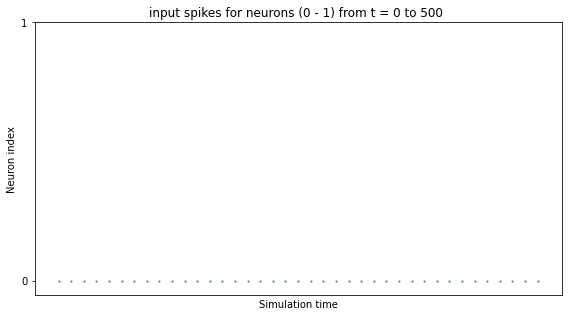

In [87]:
s_im, s_ax = None, None
s_im, s_ax = plot_spikes({
    "input": network.monitors["input_monitor"].get("s"),
}, ims=s_im, axes=s_ax)

result = network.monitors["input_monitor"].get("s").data

frequency = 0

for el in result:
    if el[0][0]:
        frequency += 1
        
frequency /= 500

print(frequency)